In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pylab as plt

In [4]:
# 读取数据，pd.read_csv默认生成DataFrame对象，需将其转换成Series对象
df = pd.read_csv('AirPassengers.csv', encoding='utf-8', index_col='TravelDate')
df.index = pd.to_datetime(df.index)  # 将字符串索引转换成时间索引
ts = df['Passengers']  # 生成pd.Series对象
# 查看数据格式
ts.head()
ts.head().index 

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01'],
              dtype='datetime64[ns]', name='TravelDate', freq=None)

In [7]:
ts['1949-01-01']
ts[datetime(1949,1,1)]

112

In [8]:
ts['1949']

TravelDate
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: Passengers, dtype: int64

In [9]:
ts['1949-1' : '1949-6']

TravelDate
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
Name: Passengers, dtype: int64

In [32]:
# 移动平均图
def draw_trend(timeSeries, size):
    f = plt.figure(facecolor='white')
    # 对size个数据进行移动平均
    rol_mean = timeSeries.rolling(window=size).mean()
    # 对size个数据进行加权移动平均
    rol_weighted_mean = pd.ewma(timeSeries, span=size)

    timeSeries.plot(color='blue', label='Original')
    rol_mean.plot(color='red', label='Rolling Mean')
    rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()

def draw_ts(timeSeries):
    f = plt.figure(facecolor='white')
    timeSeries.plot(color='blue')
    plt.show()

'''
　　Unit Root Test
   The null hypothesis of the Augmented Dickey-Fuller is that there is a unit
   root, with the alternative that there is no unit root. That is to say the
   bigger the p-value the more reason we assert that there is a unit root
'''
def testStationarity(ts):
    dftest = adfuller(ts)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

# 自相关和偏相关图，默认阶数为31阶
def draw_acf_pacf(ts, lags=31):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts, lags=31, ax=ax1)
    ax2 = f.add_subplot(212)
    plot_pacf(ts, lags=31, ax=ax2)
    plt.show()

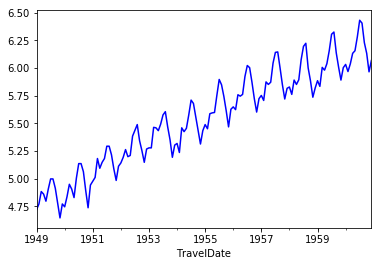

In [30]:
ts_log = np.log(ts)
draw_ts(ts_log)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=12,min_periods=0,adjust=True,ignore_na=False).mean()
  import sys


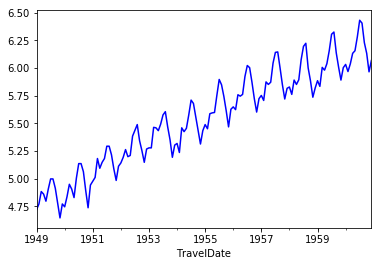

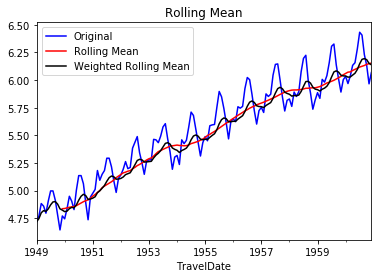

In [33]:
draw_trend(ts_log, 12)

In [34]:
diff_12 = ts_log.diff(12)
diff_12.dropna(inplace=True)
diff_12_1 = diff_12.diff(1)
diff_12_1.dropna(inplace=True)
testStationarity(diff_12_1)

Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model="additive")

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [36]:
rol_mean = ts_log.rolling(window=12).mean()
rol_mean.dropna(inplace=True)
ts_diff_1 = rol_mean.diff(1)
ts_diff_1.dropna(inplace=True)
testStationarity(ts_diff_1)

Test Statistic                  -2.709577
p-value                          0.072396
#Lags Used                      12.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64

In [37]:
ts_diff_2 = ts_diff_1.diff(1)
ts_diff_2.dropna(inplace=True)

In [38]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(ts_diff_2, order=(1, 1)) 
result_arma = model.fit( disp=-1, method='css')

In [39]:
predict_ts = result_arma.predict()
# 一阶差分还原
diff_shift_ts = ts_diff_1.shift(1)
diff_recover_1 = predict_ts.add(diff_shift_ts)
# 再次一阶差分还原
rol_shift_ts = rol_mean.shift(1)
diff_recover = diff_recover_1.add(rol_shift_ts)
# 移动平均还原
rol_sum = ts_log.rolling(window=11).sum()
rol_recover = diff_recover*12 - rol_sum.shift(1)
# 对数还原
log_recover = np.exp(rol_recover)
log_recover.dropna(inplace=True)

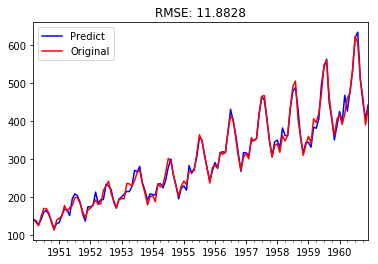

In [40]:
ts = ts[log_recover.index]  # 过滤没有预测的记录
plt.figure(facecolor='white')
log_recover.plot(color='blue', label='Predict')
ts.plot(color='red', label='Original')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((log_recover-ts)**2)/ts.size))
plt.show()